In [1]:
from dsio.anomaly_detectors import AnomalyMixin
import numpy as np
from math import exp, log


def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)


def poisson(x, l):
    return pow(l, x) * exp(-l) / factorial(x)


class OnlineEM(AnomalyMixin):
    def __init__(self, gammas, lambdas, segment_length):
        # gammas and lambdas are the initialization
        self.gammas = np.array(gammas)
        self.lambdas = np.array(lambdas)
        self.segment_length = segment_length

        assert len(gammas) == len(lambdas)

        # number of poisson mixtures
        self.m = len(gammas)

        # list of the gammas_i
        # each element represent the value of gamma_i for an iteration
        self.gammas_over_time = [[] for _ in gammas]
        self.lambdas_over_time = [[] for _ in lambdas]
        self.likelihood = []

        # number of current iteration
        self.iteration_k = 0

    def calculate_participation(self, data):
        """
        :param data: n array of the data to train
        :return: an (n, m) array of the participation of each data point to each poisson distribution
                m is the number of distributions
        """
        f = np.zeros(shape=(len(data), self.m))
        for i, x in enumerate(data):
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            f[i] = (self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas])) / total_x

        return f

    def calculate_likelihood(self, data):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in data:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def update(self, data):
        """
        :param data: the batch data 
        updates gammas, lambdas and likelihood
        """

        self.iteration_k += 1
        n = len(data)

        f = self.calculate_participation(data)

        # update gammas and lambdas
        temp_sum = f.sum(axis=0)

        update_factor = 1 / (pow(self.iteration_k, 0.6))
        self.gammas = (1 - update_factor) * self.gammas + update_factor * (temp_sum / n)

        temp = np.zeros(self.m)
        for i, x in enumerate(data):
            temp = temp + x * f[i]
        self.lambdas = (1 - update_factor) * self.lambdas + update_factor * (temp / temp_sum)

        # append last value of gammas and lambdas
        for i, gamma_i in enumerate(self.gammas):
            self.gammas_over_time[i].append(gamma_i)

        for i, lambda_i in enumerate(self.lambdas):
            self.lambdas_over_time[i].append(lambda_i)

        self.likelihood.append(self.calculate_likelihood(data))

    def get_new_batch(self, data, pos):
        n = len(data)

        assert self.segment_length <= n

        if self.segment_length + pos <= n:
            return data[pos: pos + self.segment_length], pos + self.segment_length

        return data[pos:], n

    def train(self, data):
        """
        Runs a simulated batch processing of the whole data 
        :param data: the whole data set to train from 
        :param batch_number: the number of iterations to perform on data with barch_size self.batch_size
        """

        # the starting position of the current batch in the data
        pos = 0
        while pos < len(data):
            batch, pos = self.get_new_batch(data, pos)

            self.update(batch)

    def fit(self, x):
        """
        For fitting the initial values update function is called 
        Depending on the use of the update factor initial values may have an impact or not
        :param x: data
        """
        self.update(x)

    # TODO
    def score_anomaly(self, x):
        pass

    # TODO
    def flag_anomaly(self, x):
        pass

    def get_gammas(self):
        return self.gammas_over_time

    def get_lambdas(self):
        return self.lambdas_over_time

    # TODO average or update based on factor the final likelihood?
    def get_likelihood(self):
        return self.likelihood

    def get_bic(self, data):
        """
        :return a tuple of the bic avg_log_likelihoods and the log likelihood of the whole data
        """
        """
        REMOVE?
        # get same batches as in train procedure
        pos = 0
        total_likelihood = 0
        while pos < len(data):
            batch, pos = self.get_new_batch(data, pos)
            total_likelihood += self.calculate_likelihood(batch)

        return ((-2) / self.iteration_k) * total_likelihood + log(len(data)) * (2 * self.m - 1), total_likelihood
        """
        return ((-2) / self.iteration_k) * self.calculate_likelihood(data) + log(len(data)) * (2 * self.m - 1), self.calculate_likelihood(data)
        

In [3]:
def generate_data(g, l, size):
    data = np.array([])
    sizes = [int(gi * size) for gi in g]
 
    for gi, li in zip(sizes, l):
        data = np.append(data, np.random.poisson(li, gi))
    
    np.random.shuffle(data)
    return data

data = generate_data([0.4, 0.6], [1, 5], 10000) 

Try different number of poissons to simulate the distribution of the data

In [4]:
number_of_mixtures = list(range(1,11))
avg_log_likelihoods = []
bics = []


for m in number_of_mixtures:
    onlineEM = OnlineEM([1/m]*m, list(range(1, m + 1)), 500)
    onlineEM.train(data)
    bic, avg_log_likelihood = onlineEM.get_bic(data)
    bics.append(bic)
    avg_log_likelihoods.append(avg_log_likelihood)

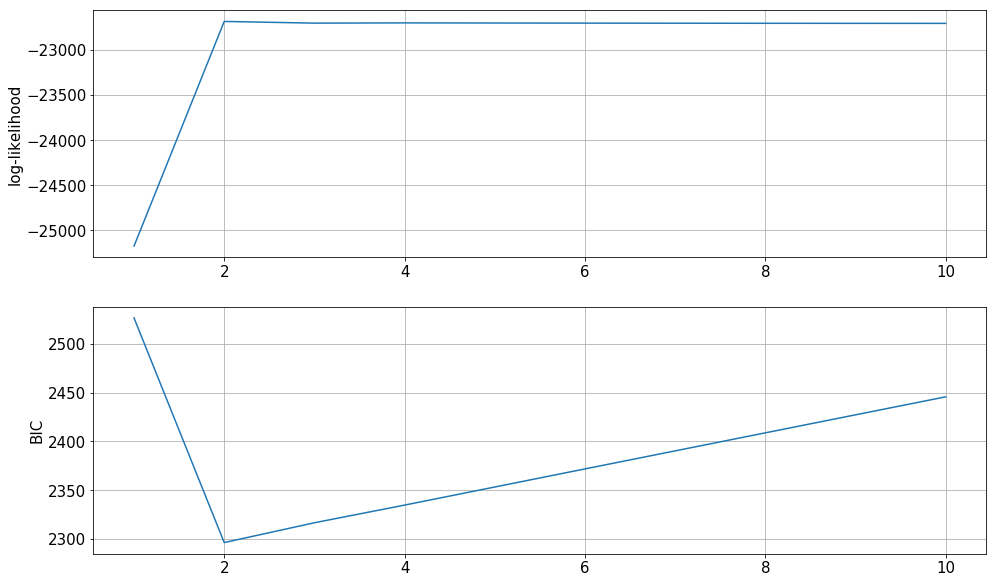

In [5]:
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 16, 10

matplotlib.rcParams.update({'font.size': 15})

plt.title('Results')

plt.subplot(2, 1, 1)
plt.plot(number_of_mixtures, avg_log_likelihoods)
plt.ylabel('log-likelihood')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(number_of_mixtures, bics)
plt.ylabel('BIC')
plt.grid()

plt.show()

From this generated data set  of course choosing a mixture of 2 poissons is the betetr choice

The average log likelihood shoould also increase with incrementing the number of mixtures. This however does not occur in this case.

In [6]:
# example fit of 3-component model in the data

onlineEM = OnlineEM([1/3]*3, [1, 2, 3], 500)
onlineEM.train(data)

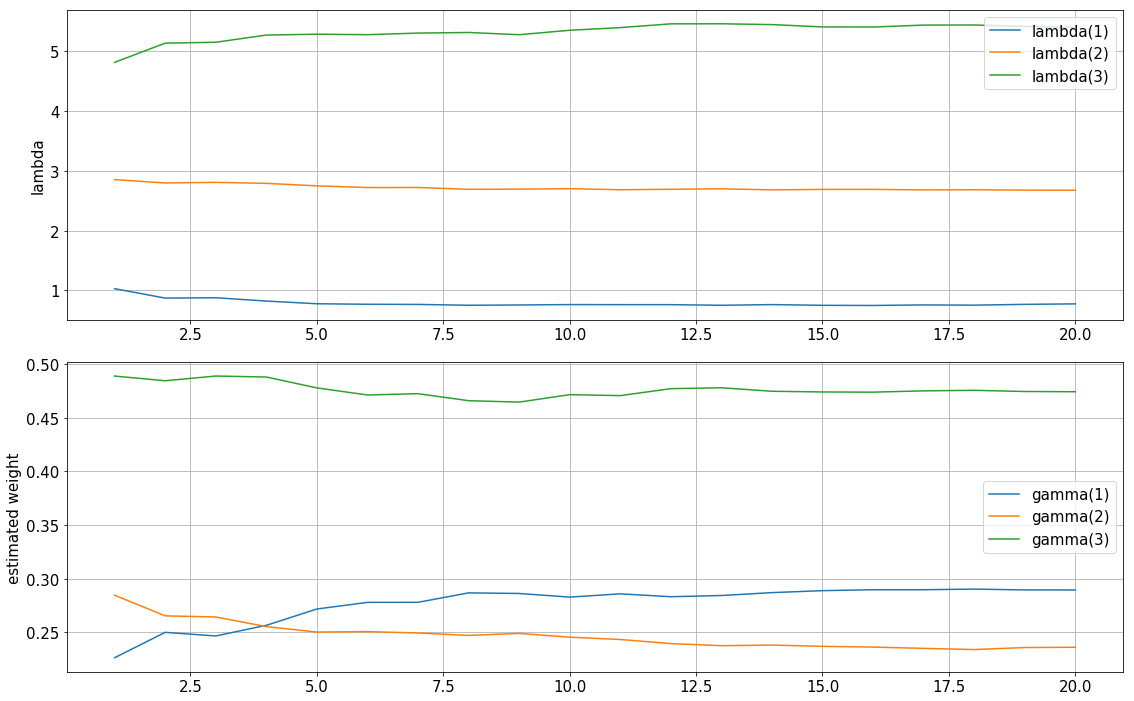

In [7]:
def plot_results(em_algorithm):
    import matplotlib
    from pylab import rcParams
    rcParams['figure.figsize'] = 16, 10
    rcParams['legend.loc'] = 'best'

    matplotlib.rcParams.update({'font.size': 15})

    x = range(1, len(em_algorithm.get_gammas()[1]) + 1)

    plt.title('Online EM 2.1 results')

    plt.subplot(2, 1, 1)
    for i in range(len(em_algorithm.get_lambdas())):
        plt.plot(x, em_algorithm.get_lambdas()[i])
    plt.ylabel('lambda')
    plt.legend([''.join(['lambda(', str(i), ')']) for i in range(1, len(em_algorithm.get_lambdas()) + 1)])
    plt.grid()

    plt.subplot(2, 1, 2)
    for i in range(len(em_algorithm.get_gammas())):
        plt.plot(x, em_algorithm.get_gammas()[i])
    plt.ylabel('estimated weight')
    plt.legend([''.join(['gamma(', str(i), ')']) for i in range(1, len(em_algorithm.get_lambdas()) + 1)])
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_results(onlineEM)

This method, at least with the proposed update factor has trouble updating quickly to changes in traffic. This may or may not be a problem.

In the folloing example, the distributions are altered after time.

In [8]:
def generate_data(g, l, size):
    data = np.array([])
    sizes = [int(gi * size) for gi in g]
 
    for gi, li in zip(sizes, l):
        data = np.append(data, np.random.poisson(li, gi))
        np.random.shuffle(data)
    return data

new_data = np.concatenate([generate_data([0.2, 0.8], [1, 5], 20000),
                           generate_data([0.3, 0.7], [2, 8], 20000),
                           generate_data([0.5, 0.5], [3, 7], 20000),
                           generate_data([0.4, 0.6], [1, 5], 20000)])

In [9]:
onlineEM = OnlineEM([0.5, 0.5], [1, 2], 500)
onlineEM.train(new_data)

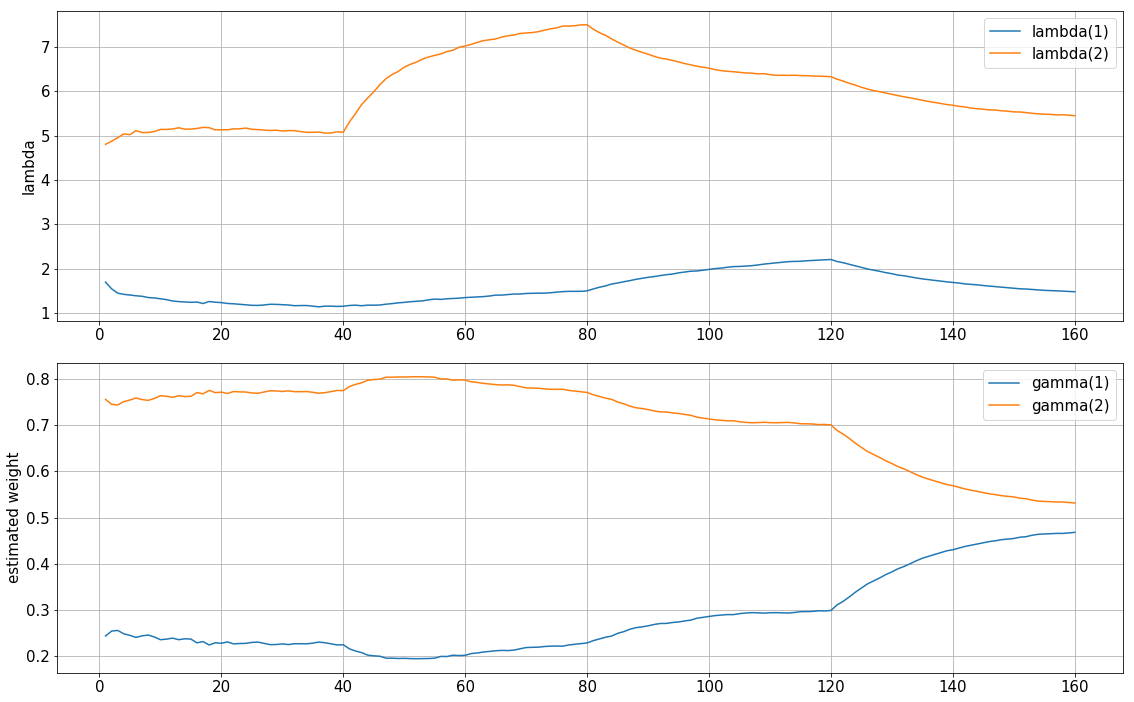

In [10]:
plot_results(onlineEM)

The update factor is reduced after time. So if the response time for the algorithm also depends on the number of iterations that have passed.

In the following examples the same change in distributions are made but after different number of samples.

In [18]:
test_data_quick = np.concatenate([generate_data([0.3, 0.7], [1, 5], 5000),
                                  generate_data([0.5, 0.5], [4, 8], 15000)])

test_data_slow = np.concatenate([generate_data([0.3, 0.7], [1, 5], 50000),
                                  generate_data([0.5, 0.5], [4, 8], 50000)])

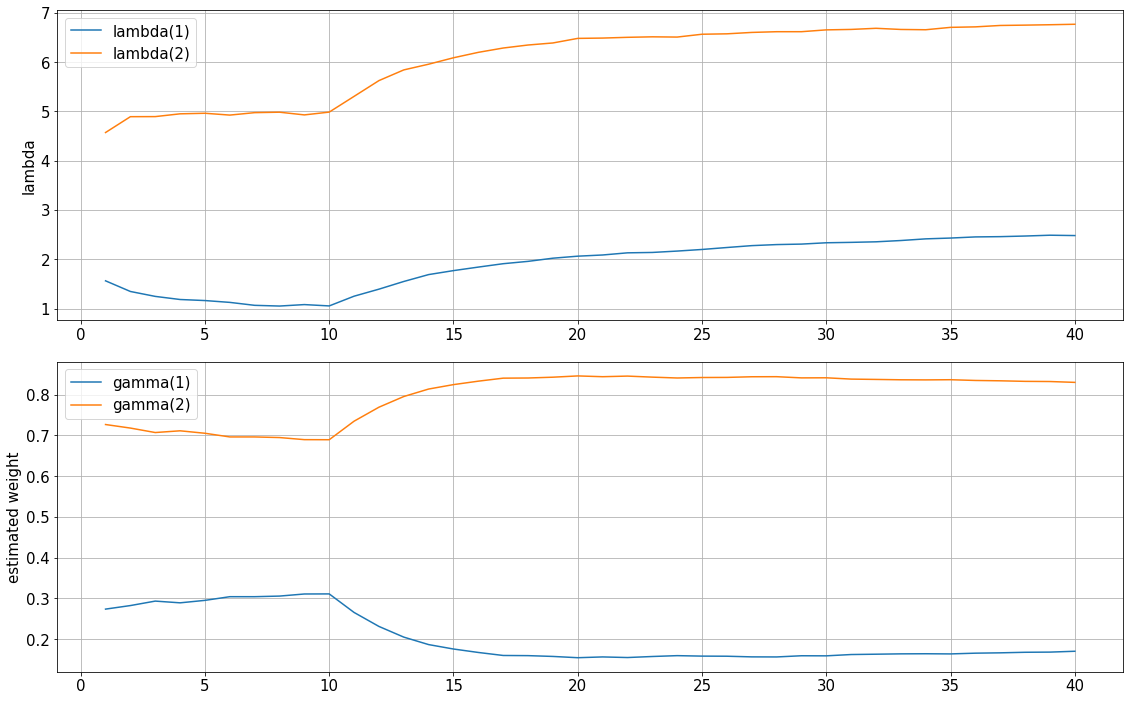

In [19]:
onlineEM_quick = OnlineEM([0.5, 0.5], [1, 2], 500)
onlineEM_quick.train(test_data_quick)
plot_results(onlineEM_quick)

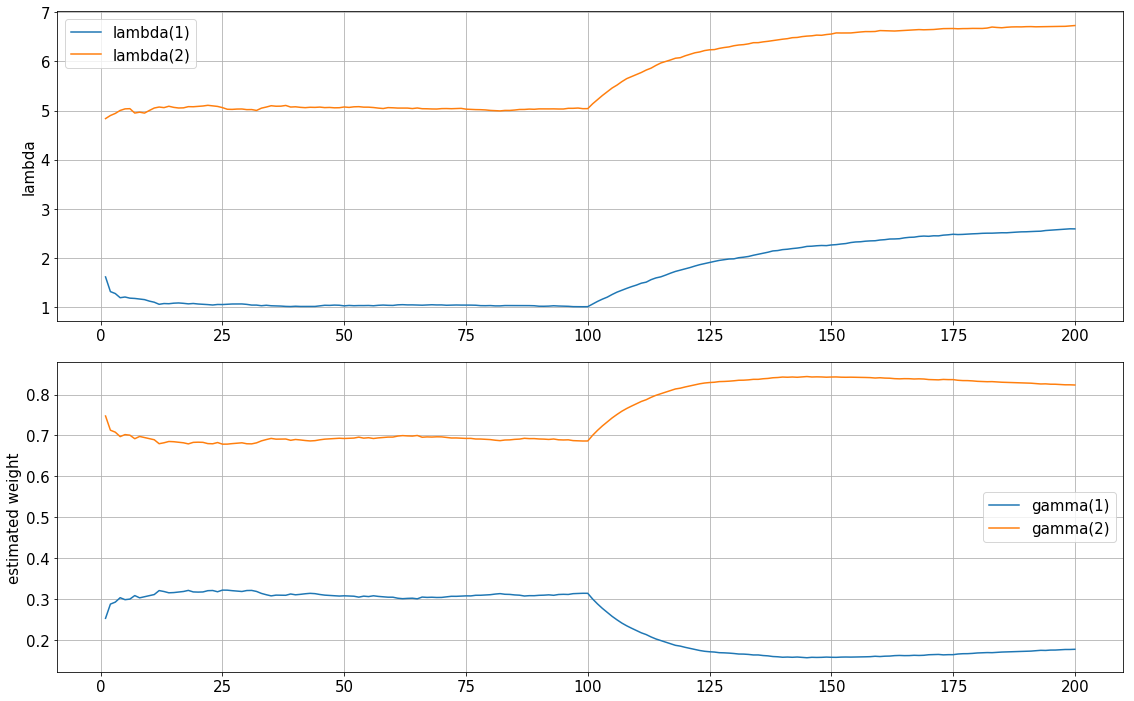

In [17]:
onlineEM_slow = OnlineEM([0.5, 0.5], [1, 2], 500)
onlineEM_slow.train(test_data_slow)
plot_results(onlineEM_slow)

The response in either case is very slow.

Chosing different update factor

Final result should also include a time based factor. Similar idea implemented in:


Density-Based Clustering over an Evolving Data Stream with Noise Feng Cao ∗ Martin Ester† Weining Qian ‡ Aoying Zhou §

In [124]:
from dsio.anomaly_detectors import AnomalyMixin
import numpy as np
from math import exp, log


def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)


def poisson(x, l):
    return pow(l, x) * exp(-l) / factorial(x)


class OnlineEMUpdateFactor(AnomalyMixin):
    def __init__(self, gammas, lambdas, segment_length):
        # gammas and lambdas are the initialization
        self.gammas = np.array(gammas)
        self.lambdas = np.array(lambdas)
        self.segment_length = segment_length

        assert len(gammas) == len(lambdas)

        # number of poisson mixtures
        self.m = len(gammas)

        # list of the gammas_i
        # each element represent the value of gamma_i for an iteration
        self.gammas_over_time = [[] for _ in gammas]
        self.lambdas_over_time = [[] for _ in lambdas]
        self.likelihood = []

        # number of current iteration
        self.iteration_k = 0
        
        """ 
        How similar are last updates to existing data
        Each time a new distribution is assumed stability is initialized to zero again
        """
        self.stability = 0
        self.consecutive_outliers = 0

    def calculate_participation(self, data):
        """
        :param data: n array of the data to train
        :return: an (n, m) array of the participation of each data point to each poisson distribution
                m is the number of distributions
        """
        f = np.zeros(shape=(len(data), self.m))
        for i, x in enumerate(data):
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            f[i] = (self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas])) / total_x

        return f

    def calculate_likelihood(self, data):
        # naive implementation for likelihood calculation
        new_likelihood = 0
        for x in data:
            total_x = np.sum(self.gammas * np.array([poisson(x, lambda_i) for lambda_i in self.lambdas]))
            new_likelihood = new_likelihood + log(total_x)
        return new_likelihood

    def calculate_update_factor(self, new_gammas, new_lambdas):
        # displays the percentage of relative outlier which can be accepted
        tolerance_factor = 0.1
        close_gammas =  np.isclose(self.gammas, new_gammas, rtol=tolerance_factor)
        close_lambdas = np.isclose(self.lambdas, new_lambdas, rtol=tolerance_factor)
        
        # if not major cahnges have happened
        if close_gammas.sum() + close_lambdas.sum() == self.m * 2:
            self.consecutive_outliers = 0
            
            self.stability += 1
            return 1 / (pow(self.stability, 0.6))
        
        self.consecutive_outliers += 1
        # don't immediately assume new distribution
        # however this is based on a batch computation
        # so perhaps we should?
        if self.consecutive_outliers < 5:
            self.stability += 1
            return 1 / (pow(self.stability, 0.6))
        
        # if too many succesive outliers assume a new distribution
        self.stability = 0
        return 0.6
        
    
    def update(self, data):
        """
        :param data: the batch data 
        updates gammas, lambdas and likelihood
        """

        self.iteration_k += 1
        n = len(data)

        f = self.calculate_participation(data)

        # update gammas and lambdas
        temp_sum = f.sum(axis=0)

        # update_factor = 1 / (pow(self.iteration_k, 0.6))
        new_gammas = (temp_sum / n)
        
        temp = np.zeros(self.m)
        for i, x in enumerate(data):
            temp = temp + x * f[i]
        new_lambdas = (temp / temp_sum)
        
        update_factor = self.calculate_update_factor(new_gammas, new_lambdas)
        
        self.gammas = (1 - update_factor) * self.gammas + update_factor * new_gammas

        self.lambdas = (1 - update_factor) * self.lambdas + update_factor * new_lambdas
        
        # append last value of gammas and lambdas
        for i, gamma_i in enumerate(self.gammas):
            self.gammas_over_time[i].append(gamma_i)

        for i, lambda_i in enumerate(self.lambdas):
            self.lambdas_over_time[i].append(lambda_i)

        self.likelihood.append(self.calculate_likelihood(data))

    def get_new_batch(self, data, pos):
        n = len(data)

        assert self.segment_length <= n

        if self.segment_length + pos <= n:
            return data[pos: pos + self.segment_length], pos + self.segment_length

        return data[pos:], n

    def train(self, data):
        """
        Runs a simulated batch processing of the whole data 
        :param data: the whole data set to train from 
        :param batch_number: the number of iterations to perform on data with barch_size self.batch_size
        """

        # the starting position of the current batch in the data
        pos = 0
        while pos < len(data):
            batch, pos = self.get_new_batch(data, pos)

            self.update(batch)

    def fit(self, x):
        """
        For fitting the initial values update function is called 
        Depending on the use of the update factor initial values may have an impact or not
        :param x: data
        """
        self.update(x)

    # TODO
    def score_anomaly(self, x):
        pass

    # TODO
    def flag_anomaly(self, x):
        pass

    def get_gammas(self):
        return self.gammas_over_time

    def get_lambdas(self):
        return self.lambdas_over_time

    # TODO average or update based on factor the final likelihood?
    def get_likelihood(self):
        return self.likelihood

    def get_bic(self, data):
        """
        :return a tuple of the bic avg_log_likelihoods and the log likelihood of the whole data
        """
        """
        REMOVE?
        # get same batches as in train procedure
        pos = 0
        total_likelihood = 0
        while pos < len(data):
            batch, pos = self.get_new_batch(data, pos)
            total_likelihood += self.calculate_likelihood(batch)

        return ((-2) / self.iteration_k) * total_likelihood + log(len(data)) * (2 * self.m - 1), total_likelihood
        """
        return ((-2) / self.iteration_k) * self.calculate_likelihood(data) + log(len(data)) * (2 * self.m - 1), self.calculate_likelihood(data)
        

In [132]:
onlineEMUpdateFactor = OnlineEMUpdateFactor([0.5, 0.5], [1, 2], 500)
onlineEMUpdateFactor.train(new_data)

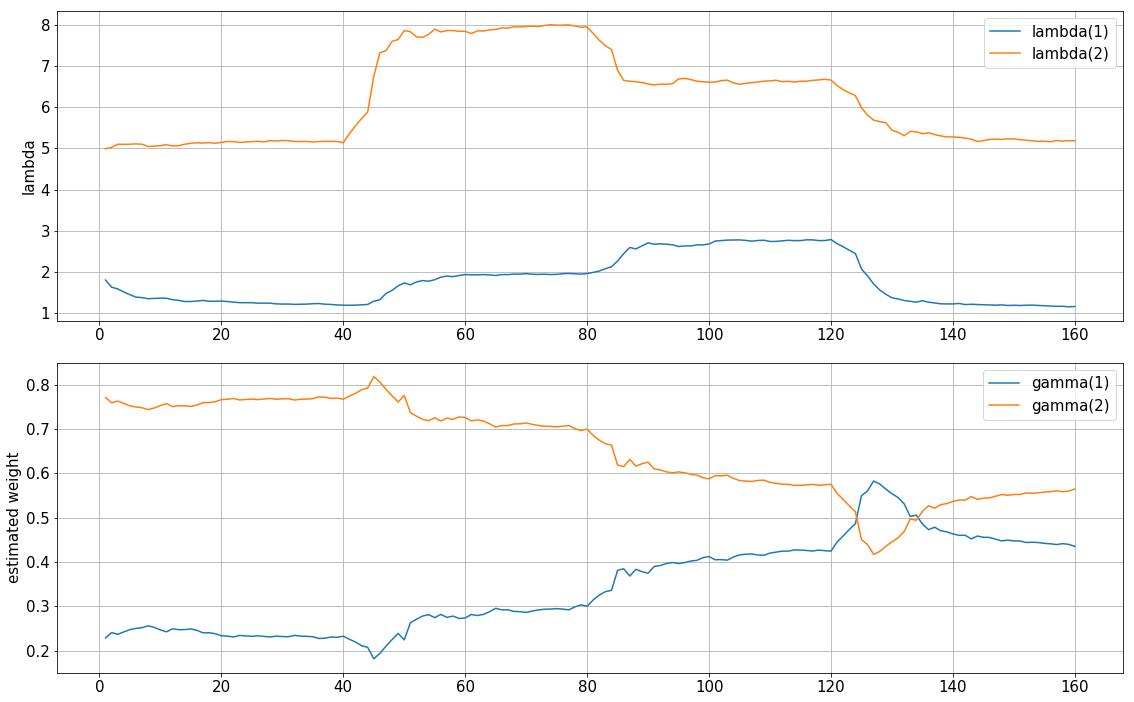

In [126]:
"""
Reminder: true distribution
    new_data = np.concatenate([generate_data([0.2, 0.8], [1, 5], 20000),
                           generate_data([0.3, 0.7], [2, 8], 20000),
                           generate_data([0.5, 0.5], [3, 7], 20000),
                           generate_data([0.4, 0.6], [1, 5], 20000)])
"""

plot_results(onlineEMUpdateFactor)

In [241]:
def compare_results(em_algorithms):
    assert len(em_algorithms) > 0
    
    batch_samples = len(em_algorithms[0].get_gammas()[0])
    for em_algo in em_algorithms:
        assert len(em_algo.get_gammas()[0]) == batch_samples
    
    import matplotlib
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    from pylab import rcParams
    rcParams['figure.figsize'] = 16, 10

    matplotlib.rcParams.update({'font.size': 15})

    batch_samples = range(1, len(em_algorithms[0].get_gammas()[0]) + 1)

    
    fig = plt.figure()

    colors = ['blue', 'green', 'red', 'black']
    styles = ['solid', 'dotted', '--', ':']    
    
    plt.subplot(2, 1, 1)
    for index, em_algorithm in enumerate(em_algorithms):
        for i in range(len(em_algorithm.get_lambdas())):
            plt.plot(batch_samples, em_algorithm.get_lambdas()[i], color=colors[i % len(colors)], linestyle=styles[index % len(styles)])
    plt.ylabel('lambda')
    #plt.legend([''.join(['lambda(', str(i), ')']) for i in range(1, len(em_algorithm.get_lambdas()) + 1)])
    
    patches = []
    for i in range(len(em_algorithms[0].get_lambdas())):
        patches.append(mpatches.Patch(color=colors[i % len(colors)], label='lambda(' + str(i) + ')'))

    plt.legend(handles=patches, loc='upper right')
    plt.grid()

    plt.subplot(2, 1, 2)
    for index, em_algorithm in enumerate(em_algorithms):
        for i in range(len(em_algorithm.get_gammas())):
            plt.plot(batch_samples, em_algorithm.get_gammas()[i], color=colors[i % len(colors)], linestyle=styles[index % len(styles)])
    plt.ylabel('gamma')
    #plt.legend([''.join(['lambda(', str(i), ')']) for i in range(1, len(em_algorithm.get_lambdas()) + 1)])
    
    patches = []
    for i in range(len(em_algorithms[0].get_gammas())):
        patches.append(mpatches.Patch(color=colors[i % len(colors)], label='gamma(' + str(i) + ')'))

    legend = plt.legend(handles=patches, loc='upper right')
    plt.gca().add_artist(legend)
    plt.grid()
    
    lines = []
    for i in range(len(em_algorithms)):
        lines.append(mlines.Line2D([], [], color='black', linestyle=styles[i % len(styles)], linewidth=3 ,label=em_algorithms[i].__class__.__name__))
        #patches.append(mpatches.Patch(capstyle='round', color='black', linestyle=styles[i % len(styles)], fill=False, label=em_algorithms[i].__class__.__name__))
    plt.legend(handles=lines, loc='upper left', bbox_to_anchor=[0, 2.4])
    
    plt.tight_layout()
    plt.show()

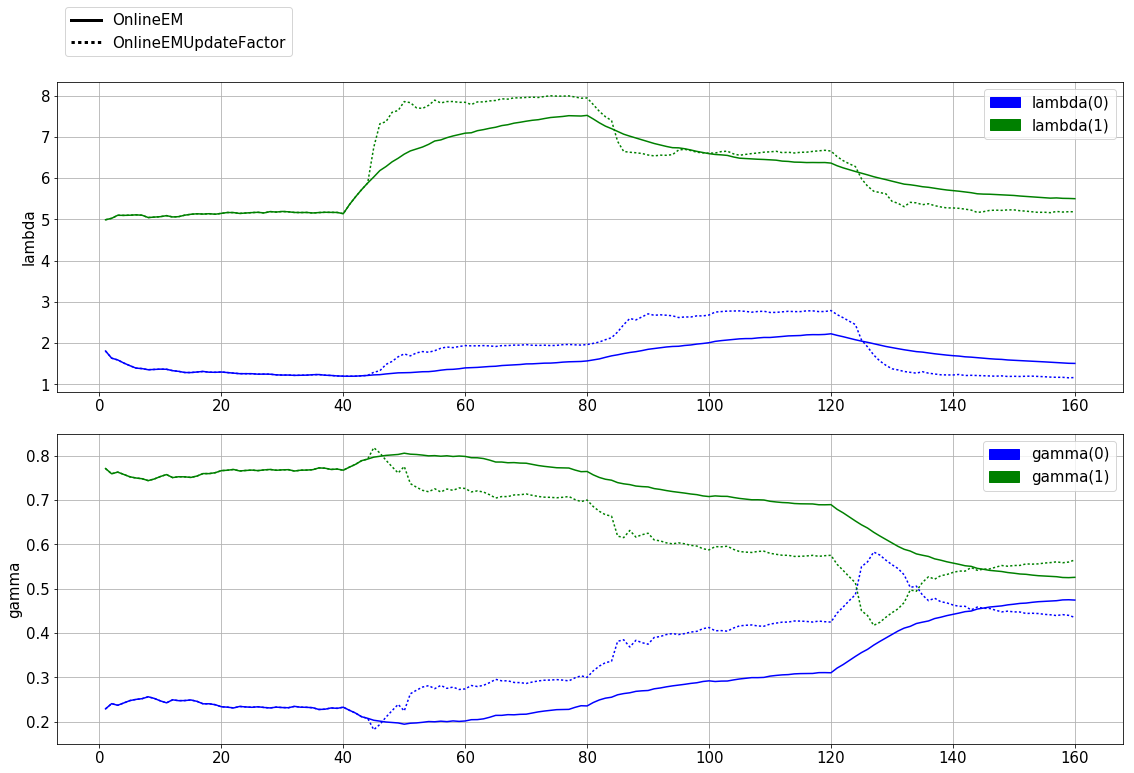

In [242]:
compare_results([onlineEM, onlineEMUpdateFactor])